# License Plate Detection & OCR
Detect license plates using YOLO and extract text using PaddleOCR

In [37]:
# Import libraries
from ultralytics import YOLO
from paddleocr import PaddleOCR
import cv2
import matplotlib.pyplot as plt
from pathlib import Path
import os

In [38]:
# Load model
model = YOLO('runs/detect/train5/weights/best.pt')
ocr = PaddleOCR(use_textline_orientation=True, lang='en')

Creating model: ('PP-LCNet_x1_0_doc_ori', None)
Model files already exist. Using cached files. To redownload, please delete the directory manually: `C:\Users\Bhupesh_K\.paddlex\official_models\PP-LCNet_x1_0_doc_ori`.
Creating model: ('UVDoc', None)
Model files already exist. Using cached files. To redownload, please delete the directory manually: `C:\Users\Bhupesh_K\.paddlex\official_models\UVDoc`.
Creating model: ('PP-LCNet_x1_0_textline_ori', None)
Model files already exist. Using cached files. To redownload, please delete the directory manually: `C:\Users\Bhupesh_K\.paddlex\official_models\PP-LCNet_x1_0_textline_ori`.
Creating model: ('PP-OCRv5_server_det', None)
Model files already exist. Using cached files. To redownload, please delete the directory manually: `C:\Users\Bhupesh_K\.paddlex\official_models\PP-OCRv5_server_det`.
Creating model: ('en_PP-OCRv5_mobile_rec', None)
Model files already exist. Using cached files. To redownload, please delete the directory manually: `C:\Users

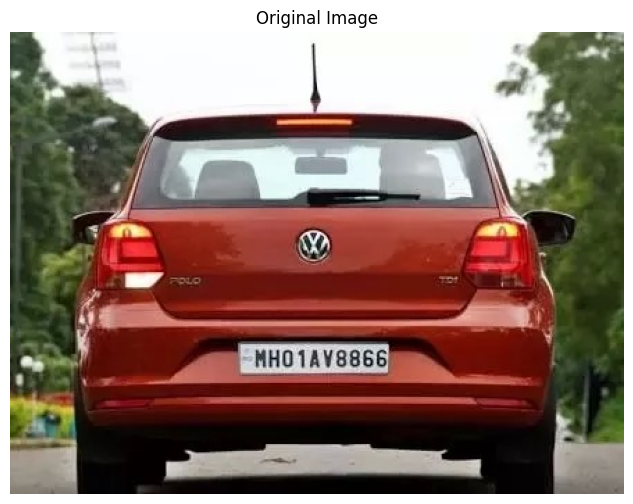

In [39]:
# Load and display image
image_path = 'White-2BPlate.jpeg'
img = cv2.imread(image_path)
img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(10, 6))
plt.imshow(img_rgb)
plt.title('Original Image')
plt.axis('off')
plt.show()

In [40]:
# Detect license plates
results = model.predict(source=image_path, conf=0.25, save=False)
result = results[0]

print(f"Number of plates detected: {len(result.boxes)}")


image 1/1 e:\yolo8n final detection - Copy (2)\White-2BPlate.jpeg: 320x416 1 license_plate, 41.9ms
Speed: 2.1ms preprocess, 41.9ms inference, 1.1ms postprocess per image at shape (1, 3, 320, 416)
Number of plates detected: 1


Plate confidence: 0.883


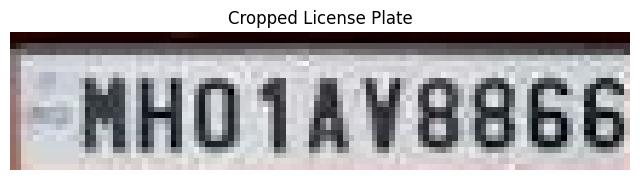

In [41]:
# Extract plate region
for box in result.boxes:
    x1, y1, x2, y2 = box.xyxy[0].cpu().numpy().astype(int)
    conf = box.conf[0].cpu().numpy()
    
    # Crop plate
    plate_region = img[y1:y2, x1:x2]
    plate_rgb = cv2.cvtColor(plate_region, cv2.COLOR_BGR2RGB)
    
    print(f"Plate confidence: {conf:.3f}")
    plt.figure(figsize=(8, 3))
    plt.imshow(plate_rgb)
    plt.title('Cropped License Plate')
    plt.axis('off')
    plt.show()

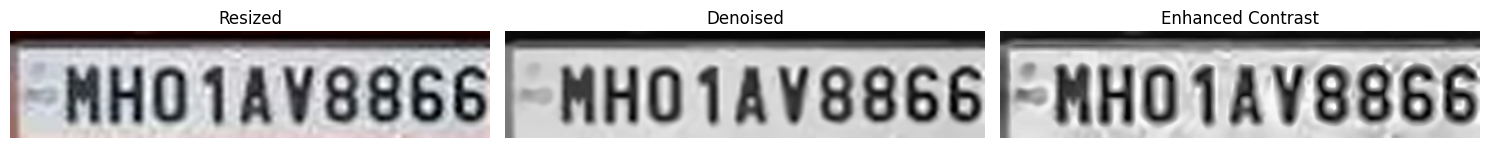

In [42]:
# Preprocess plate for better OCR
# Resize if too small
h, w = plate_region.shape[:2]
if h < 100:
    scale = 100 / h
    plate_resized = cv2.resize(plate_region, None, fx=scale, fy=scale, interpolation=cv2.INTER_CUBIC)
else:
    plate_resized = plate_region.copy()

# Convert to grayscale
gray = cv2.cvtColor(plate_resized, cv2.COLOR_BGR2GRAY)

# Denoise
denoised = cv2.fastNlMeansDenoising(gray, None, 10, 7, 21)

# Enhance contrast with CLAHE
clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(8,8))
enhanced = clahe.apply(denoised)

# Show preprocessing steps
fig, axes = plt.subplots(1, 3, figsize=(15, 4))
axes[0].imshow(cv2.cvtColor(plate_resized, cv2.COLOR_BGR2RGB))
axes[0].set_title('Resized')
axes[0].axis('off')

axes[1].imshow(denoised, cmap='gray')
axes[1].set_title('Denoised')
axes[1].axis('off')

axes[2].imshow(enhanced, cmap='gray')
axes[2].set_title('Enhanced Contrast')
axes[2].axis('off')
plt.tight_layout()
plt.show()

In [43]:
# OCR on original plate
ocr_result1 = ocr.predict(plate_region)

text1 = ""
score1 = 0
if ocr_result1 and len(ocr_result1) > 0:
    rec_texts = ocr_result1[0].get('rec_texts', [])
    rec_scores = ocr_result1[0].get('rec_scores', [])
    if rec_texts:
        text1 = ' '.join(rec_texts)
        score1 = rec_scores[0] if rec_scores else 0

print("Original Plate OCR:")
print(f"  Text: {text1}")
print(f"  Confidence: {score1:.3f}")

Original Plate OCR:
  Text: MHO1AV8868
  Confidence: 0.932


In [44]:
# OCR on enhanced plate
enhanced_bgr = cv2.cvtColor(enhanced, cv2.COLOR_GRAY2BGR)
ocr_result2 = ocr.predict(enhanced_bgr)

text2 = ""
score2 = 0
if ocr_result2 and len(ocr_result2) > 0:
    rec_texts = ocr_result2[0].get('rec_texts', [])
    rec_scores = ocr_result2[0].get('rec_scores', [])
    if rec_texts:
        text2 = ' '.join(rec_texts)
        score2 = rec_scores[0] if rec_scores else 0

print("Enhanced Plate OCR:")
print(f"  Text: {text2}")
print(f"  Confidence: {score2:.3f}")

# Choose best result
if score2 > score1:
    final_text = text2
    final_score = score2
    print(f"\n✓ Using enhanced result: {final_text}")
else:
    final_text = text1
    final_score = score1
    print(f"\n✓ Using original result: {final_text}")

Enhanced Plate OCR:
  Text: MHO1AV8866
  Confidence: 0.962

✓ Using enhanced result: MHO1AV8866


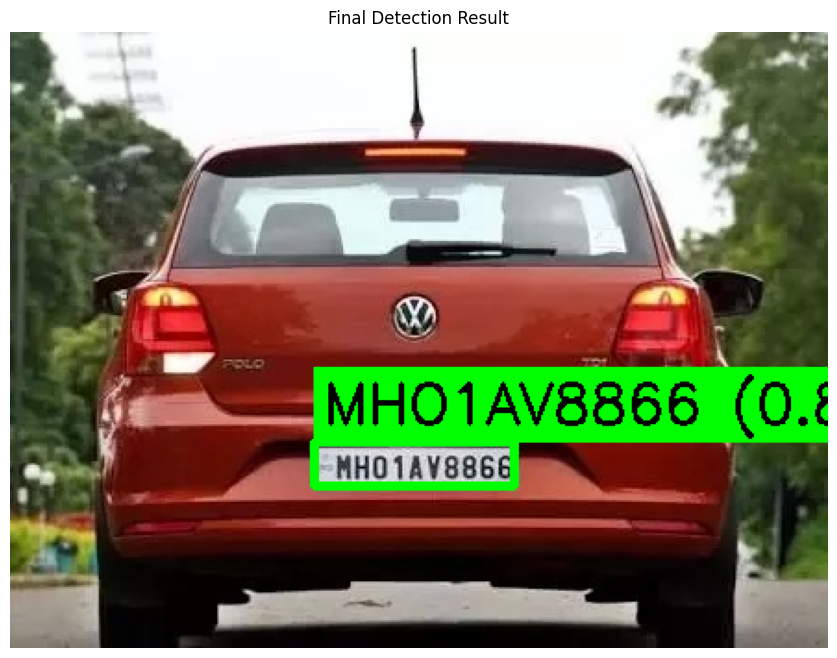


License Plate: MHO1AV8866
Detection Confidence: 0.883
OCR Confidence: 0.962


In [45]:
# Visualize final result
result_img = img_rgb.copy()
cv2.rectangle(result_img, (x1, y1), (x2, y2), (0, 255, 0), 3)

label = f"{final_text} ({conf:.2f})"
(w, h), _ = cv2.getTextSize(label, cv2.FONT_HERSHEY_SIMPLEX, 1.0, 2)
cv2.rectangle(result_img, (x1, y1-40), (x1+w+10, y1), (0, 255, 0), -1)
cv2.putText(result_img, label, (x1+5, y1-10), cv2.FONT_HERSHEY_SIMPLEX, 1.0, (0, 0, 0), 2)

plt.figure(figsize=(12, 8))
plt.imshow(result_img)
plt.title('Final Detection Result')
plt.axis('off')
plt.show()

print(f"\n{'='*50}")
print(f"License Plate: {final_text}")
print(f"Detection Confidence: {conf:.3f}")
print(f"OCR Confidence: {final_score:.3f}")
print(f"{'='*50}")

In [46]:
# Save result to CSV
import pandas as pd
from datetime import datetime

# Create data
data = {
    'timestamp': [datetime.now().strftime('%Y-%m-%d %H:%M:%S')],
    'image_name': [os.path.basename(image_path)],
    'license_plate': [final_text],
    'detection_confidence': [conf],
    'ocr_confidence': [final_score],
    'bbox': [f"({x1},{y1},{x2},{y2})"]
}

df = pd.DataFrame(data)

# Save to CSV (append mode)
csv_file = 'license_plates.csv'
if os.path.exists(csv_file):
    df.to_csv(csv_file, mode='a', header=False, index=False)
    print(f"✓ Result appended to {csv_file}")
else:
    df.to_csv(csv_file, index=False)
    print(f"✓ Result saved to {csv_file}")

# Display the CSV
print(f"\nLatest entry:")
print(df.to_string(index=False))

✓ Result appended to license_plates.csv

Latest entry:
          timestamp         image_name license_plate detection_confidence  ocr_confidence              bbox
2025-11-11 15:29:23 White-2BPlate.jpeg    MHO1AV8866           0.88274866        0.961788 (164,221,272,245)


## Test Multiple Images from Different States

Testing 5 images from different states

Processing: archive (2)/State-wise_OLX/MH/MH1.jpg
✓ Detected: MH"06 AB 86
  Detection: 0.939 | OCR: 0.924
Processing: archive (2)/State-wise_OLX/DL/DL1.jpg
✓ Detected: DL 6CJ8402
  Detection: 0.874 | OCR: 0.901
Processing: archive (2)/State-wise_OLX/KA/KA1.jpg
✓ Detected: KA03MO6984
  Detection: 0.910 | OCR: 0.968
Processing: archive (2)/State-wise_OLX/TN/TN1.jpg
✓ Detected: TK638Y795
  Detection: 0.878 | OCR: 0.934
Processing: archive (2)/State-wise_OLX/GJ/GJ1.jpg
✓ Detected: GJ7AG4373
  Detection: 0.746 | OCR: 0.999


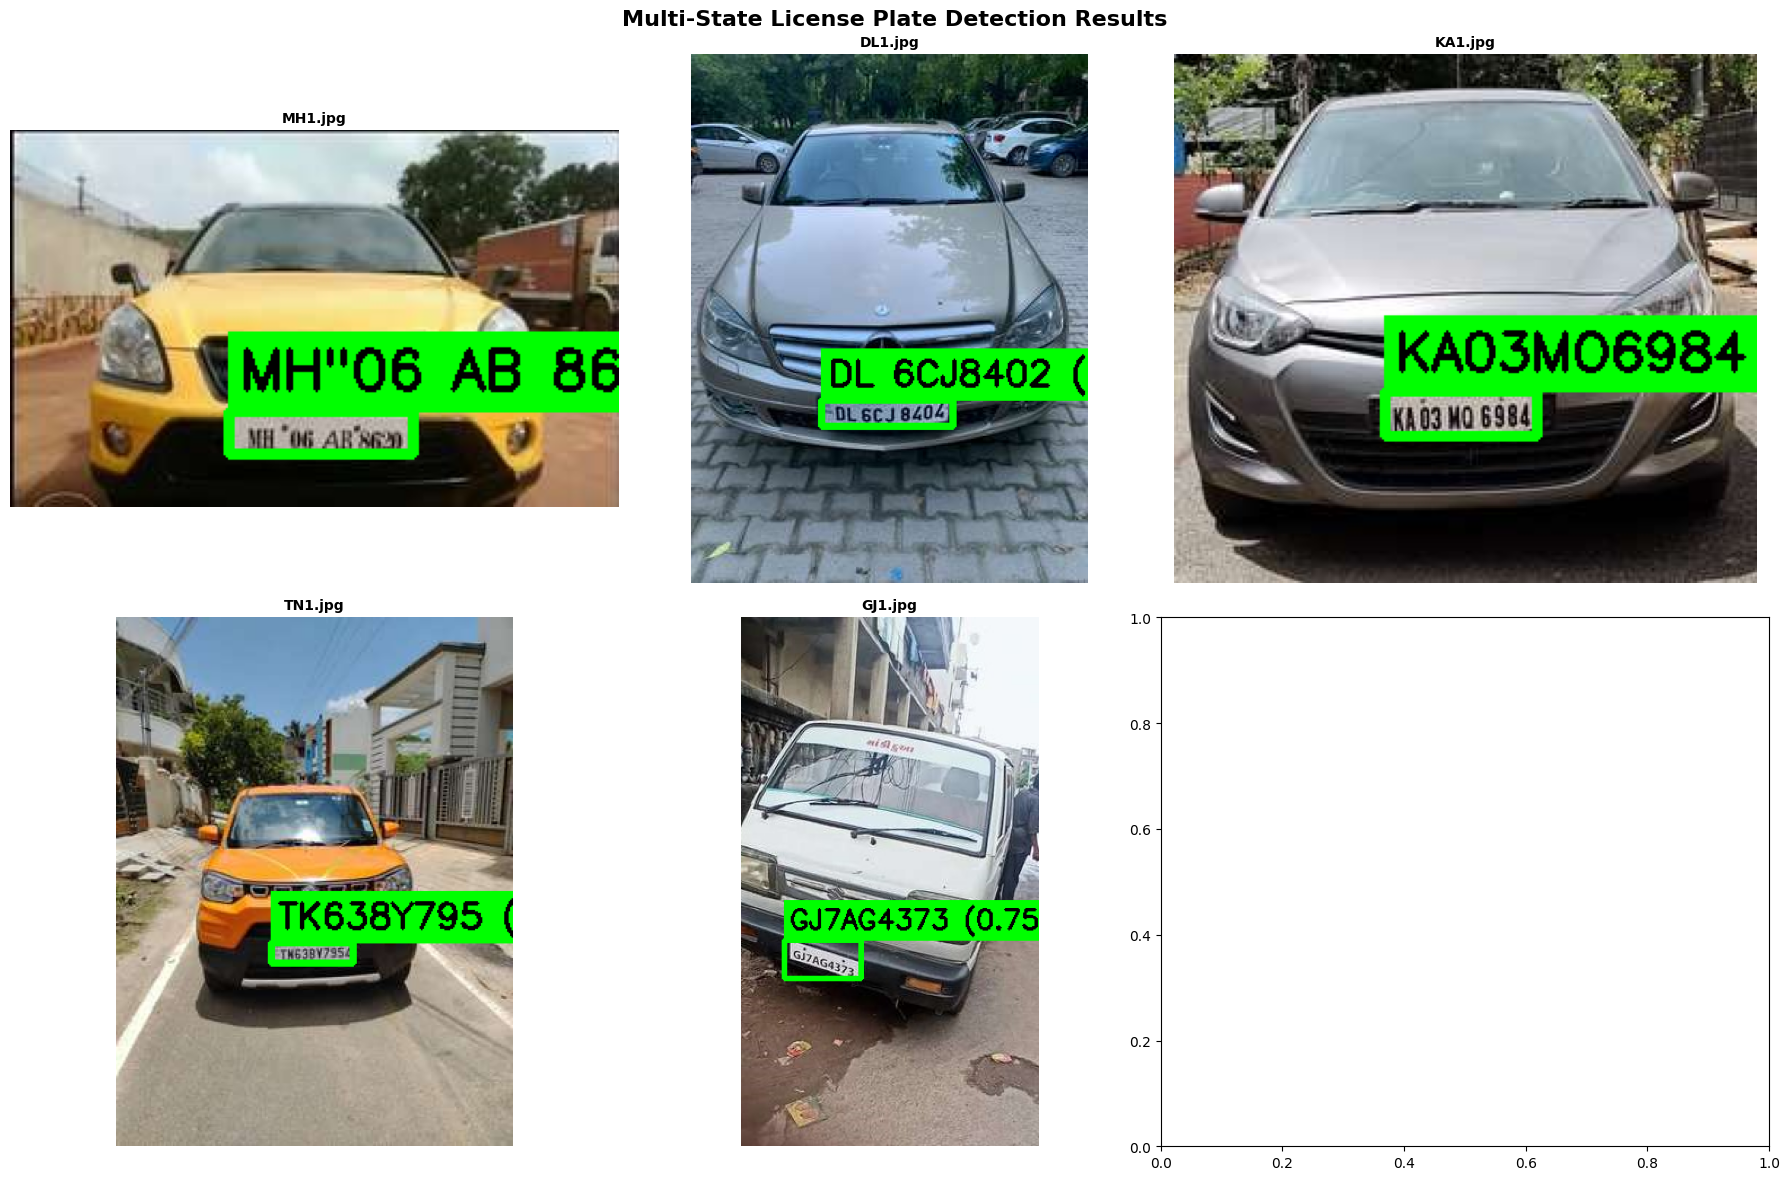


✓ 5 results saved to license_plates.csv

Summary:
  Total images processed: 5
  Plates detected: 5
  Avg detection confidence: 0.869
  Avg OCR confidence: 0.945


In [47]:
# Test images from different states
import pandas as pd
from datetime import datetime

# Define test images from different states
test_images = [
    'archive (2)/State-wise_OLX/MH/MH1.jpg',
    'archive (2)/State-wise_OLX/DL/DL1.jpg',
    'archive (2)/State-wise_OLX/KA/KA1.jpg',
    'archive (2)/State-wise_OLX/TN/TN1.jpg',
    'archive (2)/State-wise_OLX/GJ/GJ1.jpg',
    'archive (2)/State-wise_OLX/RJ/RJ1.jpg',
]

# Filter existing images
test_images = [img for img in test_images if os.path.exists(img)]

print(f"Testing {len(test_images)} images from different states\n")

# Process each image
results_list = []

fig, axes = plt.subplots(2, 3, figsize=(18, 12))
axes = axes.flatten()

for idx, img_path in enumerate(test_images):
    print(f"{'='*60}")
    print(f"Processing: {img_path}")
    
    # Read image
    img = cv2.imread(img_path)
    img_rgb = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    # Detect plates
    results = model.predict(source=img_path, conf=0.25, save=False, verbose=False)
    result = results[0]
    
    if len(result.boxes) > 0:
        for box in result.boxes:
            x1, y1, x2, y2 = box.xyxy[0].cpu().numpy().astype(int)
            conf = box.conf[0].cpu().numpy()
            
            # Extract plate region
            plate_region = img[y1:y2, x1:x2]
            
            # Resize if needed
            h, w = plate_region.shape[:2]
            if h < 100:
                scale = 100 / h
                plate_resized = cv2.resize(plate_region, None, fx=scale, fy=scale, interpolation=cv2.INTER_CUBIC)
            else:
                plate_resized = plate_region.copy()
            
            # Preprocess
            gray = cv2.cvtColor(plate_resized, cv2.COLOR_BGR2GRAY)
            denoised = cv2.fastNlMeansDenoising(gray, None, 10, 7, 21)
            clahe = cv2.createCLAHE(clipLimit=3.0, tileGridSize=(8,8))
            enhanced = clahe.apply(denoised)
            
            # OCR on original
            ocr_result1 = ocr.predict(plate_region)
            text1, score1 = "", 0
            if ocr_result1 and len(ocr_result1) > 0:
                rec_texts = ocr_result1[0].get('rec_texts', [])
                rec_scores = ocr_result1[0].get('rec_scores', [])
                if rec_texts and rec_scores:
                    text1 = ' '.join(rec_texts)
                    score1 = rec_scores[0]
            
            # OCR on enhanced
            enhanced_bgr = cv2.cvtColor(enhanced, cv2.COLOR_GRAY2BGR)
            ocr_result2 = ocr.predict(enhanced_bgr)
            text2, score2 = "", 0
            if ocr_result2 and len(ocr_result2) > 0:
                rec_texts = ocr_result2[0].get('rec_texts', [])
                rec_scores = ocr_result2[0].get('rec_scores', [])
                if rec_texts and rec_scores:
                    text2 = ' '.join(rec_texts)
                    score2 = rec_scores[0]
            
            # Choose best
            if score2 > score1:
                final_text = text2
                final_score = score2
            else:
                final_text = text1
                final_score = score1
            
            # Draw on image
            cv2.rectangle(img_rgb, (x1, y1), (x2, y2), (0, 255, 0), 3)
            label = f"{final_text} ({conf:.2f})"
            (w, h), _ = cv2.getTextSize(label, cv2.FONT_HERSHEY_SIMPLEX, 0.8, 2)
            cv2.rectangle(img_rgb, (x1, y1-35), (x1+w+10, y1), (0, 255, 0), -1)
            cv2.putText(img_rgb, label, (x1+5, y1-10), 
                       cv2.FONT_HERSHEY_SIMPLEX, 0.8, (0, 0, 0), 2)
            
            # Store result
            results_list.append({
                'timestamp': datetime.now().strftime('%Y-%m-%d %H:%M:%S'),
                'image_name': os.path.basename(img_path),
                'license_plate': final_text,
                'detection_confidence': conf,
                'ocr_confidence': final_score,
                'bbox': f"({x1},{y1},{x2},{y2})"
            })
            
            print(f"✓ Detected: {final_text}")
            print(f"  Detection: {conf:.3f} | OCR: {final_score:.3f}")
    else:
        print("✗ No plate detected")
    
    # Display in subplot
    axes[idx].imshow(img_rgb)
    axes[idx].set_title(os.path.basename(img_path), fontsize=10, fontweight='bold')
    axes[idx].axis('off')

plt.suptitle('Multi-State License Plate Detection Results', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

# Save all results to CSV
if results_list:
    df = pd.DataFrame(results_list)
    csv_file = 'license_plates.csv'
    if os.path.exists(csv_file):
        df.to_csv(csv_file, mode='a', header=False, index=False)
    else:
        df.to_csv(csv_file, index=False)
    
    print(f"\n{'='*60}")
    print(f"✓ {len(results_list)} results saved to {csv_file}")
    print(f"\nSummary:")
    print(f"  Total images processed: {len(test_images)}")
    print(f"  Plates detected: {len(results_list)}")
    print(f"  Avg detection confidence: {df['detection_confidence'].mean():.3f}")
    print(f"  Avg OCR confidence: {df['ocr_confidence'].mean():.3f}")
    print(f"{'='*60}")